# Forecasting Water Levels using LSTMs

In [225]:
import IPython.display
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from datetime import timedelta
from wetterdienst import Wetterdienst, Period, Resolution
from wetterdienst.provider.dwd.observation import DwdObservationRequest, \
    DwdObservationPeriod, DwdObservationResolution, DwdObservationParameter, DwdObservationDataset

In [226]:
path = 'results/'  # Path for saving the figures later on

First, look at any missing or duplicate values in the dataset.

In [227]:
df = pd.read_csv('data/Kaub_Level_Since_2013_updated_v2.csv')
x = df[df.duplicated(['date'])].index
print(f' Show duplicate values, if any: {x.values}')

 Show duplicate values, if any: []


In [228]:
df_index = df.set_index(df['date'])
df_index.index = pd.to_datetime(df_index.index)
dates_original = pd.date_range(start=df['date'].iloc[0], end=df['date'].iloc[-1]).difference(df_index.index)
print('These are the missing dates on the updated data, if any: \n', dates_original.values)
print(f'There are a total of {len(dates_original)} dates missing.')

These are the missing dates on the updated data, if any: 
 []
There are a total of 0 dates missing.


Look at available stations near the Rhine. This is done by only filtering the state Baden Württemberg and also using only stations that have also recent data available, because some of the stations have seemingly not been used anymore in the last few years.

In [229]:
stations = DwdObservationRequest(parameter=DwdObservationDataset.PRECIPITATION_MORE,resolution=Resolution.DAILY,period=Period.HISTORICAL)

In [230]:
stat = stations.all().df
stat[(stat['state'] == 'Baden-Württemberg') & (stat['to_date'] == '2021-12-12 00:00:00+00:00')].sort_values(by='name')

,station_id,from_date,to_date,height,latitude,longitude,name,state
1483,01680,1931-01-01 00:00:00+00:00,2021-12-12 00:00:00+00:00,368.0,48.6889,9.6345,Göppingen-Jebenhausen,Baden-Württemberg


In [231]:
stat[stat['name'] == 'Säckingen, Bad/ Rhein']

,station_id,from_date,to_date,height,latitude,longitude,name,state
3899,04351,1951-01-01 00:00:00+00:00,2021-12-18 00:00:00+00:00,295.0,47.5582,7.9773,"Säckingen, Bad/ Rhein",Baden-Württemberg


Next, implement a function in order to get the station ID given a name of a city. This is needed for the later API calls on the DWD data.

In [232]:
def get_station_id(city):
    request = DwdObservationRequest(
        parameter=DwdObservationDataset.PRECIPITATION_MORE,
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    )
    df = request.all().df
    station_string = df[df['name'] == city].station_id
    return int(station_string.iloc[0][1:])


Note: There is no Ludwigshafen in the DWD weather API, so I use Mannheim instead.

In [233]:
ma_id = get_station_id('Mannheim')
frei_id = get_station_id('Freiburg')
rheinau_id = get_station_id('Rheinau-Memprechtshofen')
rheinfelden_id = get_station_id('Rheinfelden')
rheinstetten_id = get_station_id('Rheinstetten')

The next functions returns data of the DWD given a specified station.

In [234]:
def get_historical_data(station_id):
    request = DwdObservationRequest(
        parameter=[
            DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
        ],
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    ).filter_by_station_id(station_id=(station_id, ))

    return request.values.all().df

def get_recent_data(station_id):
    request = DwdObservationRequest(
        parameter=[
            DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
        ],
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.RECENT
    ).filter_by_station_id(station_id=(station_id, ))

    return request.values.all().df

In [235]:
precipitation_frei_historical = get_historical_data(frei_id)
precipitation_frei_recent = get_recent_data(frei_id)

precipitation_ma_historical = get_historical_data(ma_id)
precipitation_ma_recent= get_recent_data(ma_id)

precipitation_rheinau_historical = get_historical_data(rheinau_id)
precipitation_rheinau_recent = get_recent_data(rheinau_id)

precipitation_rheinfelden_historical = get_historical_data(rheinfelden_id)
precipitation_rheinfelden_recent = get_recent_data(rheinfelden_id)

precipitation_rheinstetten_historical = get_historical_data(rheinstetten_id)
precipitation_rheinstetten_recent = get_recent_data(rheinstetten_id)

In [236]:
precipitation_frei_historical[365:]

,station_id,dataset,parameter,date,value,quality
365,01443,climate_summary,precipitation_height,1875-01-01 00:00:00+00:00,12.2,1.0
366,01443,climate_summary,precipitation_height,1875-01-02 00:00:00+00:00,2.6,1.0
367,01443,climate_summary,precipitation_height,1875-01-03 00:00:00+00:00,5.0,1.0
368,01443,climate_summary,precipitation_height,1875-01-04 00:00:00+00:00,3.1,1.0
369,01443,climate_summary,precipitation_height,1875-01-05 00:00:00+00:00,0.0,1.0
...,...,...,...,...,...,...
43704,01443,climate_summary,precipitation_height,2020-12-27 00:00:00+00:00,13.0,3.0
43705,01443,climate_summary,precipitation_height,2020-12-28 00:00:00+00:00,5.5,3.0
43706,01443,climate_summary,precipitation_height,2020-12-29 00:00:00+00:00,0.0,3.0
43707,01443,climate_summary,precipitation_height,2020-12-30 00:00:00+00:00,0.0,3.0


In [237]:
precipitation_frei_recent[365:]

,station_id,dataset,parameter,date,value,quality
365,01443,climate_summary,precipitation_height,2021-06-17 00:00:00+00:00,0.0,3.0
366,01443,climate_summary,precipitation_height,2021-06-18 00:00:00+00:00,0.3,3.0
367,01443,climate_summary,precipitation_height,2021-06-19 00:00:00+00:00,0.4,3.0
368,01443,climate_summary,precipitation_height,2021-06-20 00:00:00+00:00,17.3,3.0
369,01443,climate_summary,precipitation_height,2021-06-21 00:00:00+00:00,3.7,3.0
...,...,...,...,...,...,...
545,01443,climate_summary,precipitation_height,2021-12-14 00:00:00+00:00,0.1,1.0
546,01443,climate_summary,precipitation_height,2021-12-15 00:00:00+00:00,0.0,1.0
547,01443,climate_summary,precipitation_height,2021-12-16 00:00:00+00:00,0.0,1.0
548,01443,climate_summary,precipitation_height,2021-12-17 00:00:00+00:00,0.0,1.0


Now, have a rough look at the historical data:

<AxesSubplot:title={'center':'Rheinstetten Historical'}, xlabel='date'>

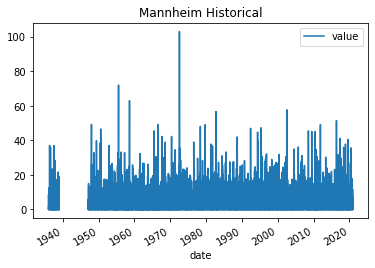

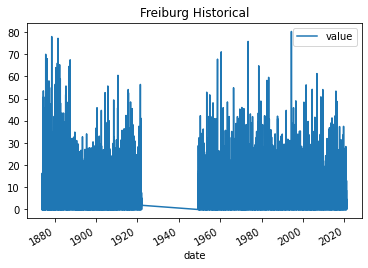

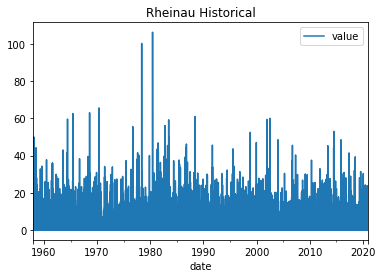

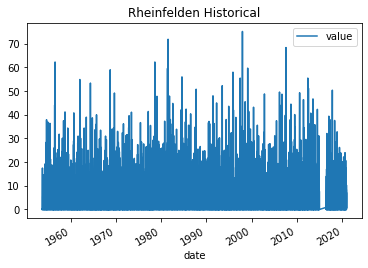

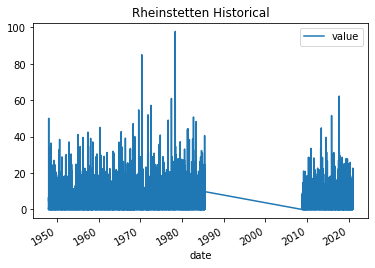

In [238]:
precipitation_ma_historical.plot(x="date", y="value", title='Mannheim Historical')
precipitation_frei_historical.plot(x='date', y='value', title='Freiburg Historical')
precipitation_rheinau_historical.plot(x='date', y='value', title='Rheinau Historical')
precipitation_rheinfelden_historical.plot(x='date', y='value', title='Rheinfelden Historical')
precipitation_rheinstetten_historical.plot(x='date', y='value', title='Rheinstetten Historical')

Based on the above data, there seems to be data missing, but because we have to align the data of the DWD to the data of the rhine water level (kaub), the data missing before 01-01-2013 is of no concern, the data missing after that date is a problem though.

<AxesSubplot:title={'center':'Closeup of Rheinfelden Historical'}, xlabel='date'>

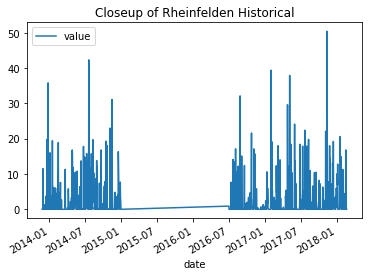

In [239]:
precipitation_rheinfelden_historical.loc[22000:23000].plot(x='date', y='value', title='Closeup of Rheinfelden Historical')

In [240]:
precipitation_rheinfelden_historical.loc[22400:22410]

,station_id,dataset,parameter,date,value,quality
22400,04175,climate_summary,precipitation_height,2014-12-30 00:00:00+00:00,0.6,10.0
22401,04175,climate_summary,precipitation_height,2014-12-31 00:00:00+00:00,0.0,10.0
22402,04175,climate_summary,precipitation_height,2016-07-01 00:00:00+00:00,0.9,10.0
22403,04175,climate_summary,precipitation_height,2016-07-02 00:00:00+00:00,0.0,10.0
22404,04175,climate_summary,precipitation_height,2016-07-03 00:00:00+00:00,0.0,10.0
22405,04175,climate_summary,precipitation_height,2016-07-04 00:00:00+00:00,0.0,10.0
22406,04175,climate_summary,precipitation_height,2016-07-05 00:00:00+00:00,0.0,10.0
22407,04175,climate_summary,precipitation_height,2016-07-06 00:00:00+00:00,0.0,10.0
22408,04175,climate_summary,precipitation_height,2016-07-07 00:00:00+00:00,0.0,10.0
22409,04175,climate_summary,precipitation_height,2016-07-08 00:00:00+00:00,0.0,10.0


Upon closer inspection, the entirety of data from 2014 until 2016 is missing. This is of great concern since filling these values with artificially created values may certainly have a bad influence on the model. This is why we decided to not include this dataset.

<AxesSubplot:title={'center':'Rheinstetten Recent'}, xlabel='date'>

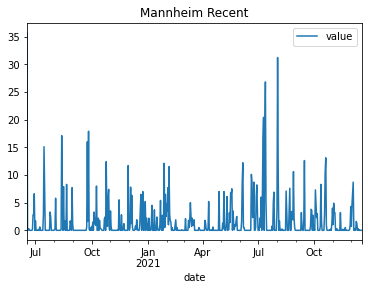

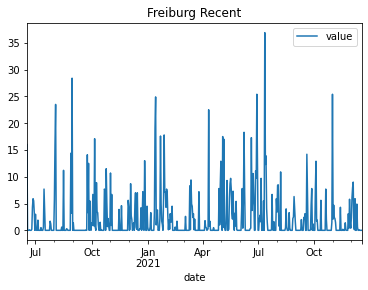

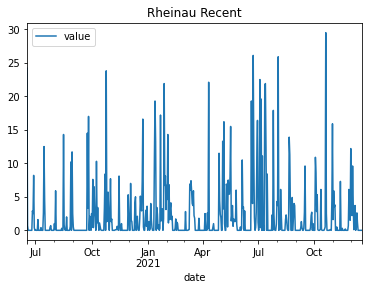

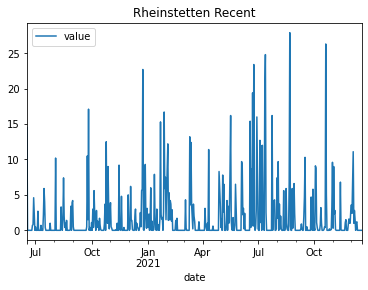

In [306]:
precipitation_ma_recent.plot(x="date", y="value", title='Mannheim Recent')
precipitation_frei_recent.plot(x="date", y="value", title='Freiburg Recent')
precipitation_rheinau_recent.plot(x="date", y="value", title='Rheinau Recent')
precipitation_rheinfelden_recent.plot(x="date", y="value", title='Rheinfelden Recent')

In [242]:
precipitation_frei_recent[:10]

,station_id,dataset,parameter,date,value,quality
0,01443,climate_summary,precipitation_height,2020-06-17 00:00:00+00:00,16.0,3.0
1,01443,climate_summary,precipitation_height,2020-06-18 00:00:00+00:00,0.0,3.0
2,01443,climate_summary,precipitation_height,2020-06-19 00:00:00+00:00,0.0,3.0
3,01443,climate_summary,precipitation_height,2020-06-20 00:00:00+00:00,0.0,3.0
4,01443,climate_summary,precipitation_height,2020-06-21 00:00:00+00:00,0.1,3.0
5,01443,climate_summary,precipitation_height,2020-06-22 00:00:00+00:00,0.0,3.0
6,01443,climate_summary,precipitation_height,2020-06-23 00:00:00+00:00,0.0,3.0
7,01443,climate_summary,precipitation_height,2020-06-24 00:00:00+00:00,0.0,3.0
8,01443,climate_summary,precipitation_height,2020-06-25 00:00:00+00:00,0.2,3.0
9,01443,climate_summary,precipitation_height,2020-06-26 00:00:00+00:00,4.3,3.0


As one can see from all the historical and recent plots, the start of the historical data differs from station to station. The end of the historical data is however always the same, i.e. the 31-12-2020. The recent data is in the timespan of [17-07-2020, now], where 'now' is the date this program is run.

In [243]:
assert(len(precipitation_ma_recent) == len(precipitation_frei_recent) == len(precipitation_rheinau_recent) == len(precipitation_rheinfelden_recent))

In [244]:
assert(precipitation_ma_recent['date'].loc[0] == precipitation_frei_recent['date'].loc[0].date() == precipitation_rheinau_recent['date'].loc[0].date() == precipitation_rheinfelden_recent['date'].loc[0].date())

/tmp/ipykernel_72705/109090159.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  assert(precipitation_ma_recent['date'].loc[0] == precipitation_frei_recent['date'].loc[0].date() == precipitation_rheinau_recent['date'].loc[0].date() == precipitation_rheinfelden_recent['date'].loc[0].date())


Put the data in lists for convenience.

In [253]:
historicals = {'Mannheim_historical' : precipitation_ma_historical,
               'Rheinfelden_historical': precipitation_rheinfelden_historical,
               'Freiburg_historical' : precipitation_frei_historical,
               'Rheinau_historical' : precipitation_rheinau_historical}
recents = {'Mannheim_recent' : precipitation_ma_recent,
           'Rheinfelden_recent': precipitation_rheinfelden_recent,
           'Freiburg_recent' : precipitation_frei_recent,
           'Rheinau_recent' : precipitation_rheinau_recent}

total = {}
total.update(recents)
total.update(historicals)

First, have a look at duplicate values:

In [263]:
for name, prec in total.items():
    print(f'The {name} dataset has {prec[prec.duplicated(["date"])].value.values} duplicate values.')

The Mannheim_recent dataset has [] duplicate values.
The Rheinfelden_recent dataset has [] duplicate values.
The Freiburg_recent dataset has [] duplicate values.
The Rheinau_recent dataset has [] duplicate values.
The Mannheim_historical dataset has [] duplicate values.
The Rheinfelden_historical dataset has [] duplicate values.
The Freiburg_historical dataset has [] duplicate values.
The Rheinau_historical dataset has [] duplicate values.


As can be seen above, there are no duplicate values by date.

Check that there are no null values in the data

In [268]:
for name, prec in recents.items():
    assert(prec.isnull().any().any() == False)

In [282]:
for name, prec in historicals.items():
    print(f'The {name} dataset has {len(prec[prec.isna().any(axis=1)].value.values)} null values')

The Mannheim_historical dataset has 3 null values
The Rheinfelden_historical dataset has 0 null values
The Freiburg_historical dataset has 205 null values
The Rheinau_historical dataset has 0 null values


There are some values missing, now show the indices of these null values:

In [287]:
for name, prec in historicals.items():
    print(f'The {name} dataset the following null values:\n{prec[prec.isna().any(axis=1)].value if len(prec[prec.isna().any(axis=1)].value.values)>0 else "No missing values"}')

The Mannheim_historical dataset the following null values:
1095    NaN
27122   NaN
27123   NaN
Name: value, dtype: float64
The Rheinfelden_historical dataset the following null values:
No missing values
The Freiburg_historical dataset the following null values:
58      NaN
84      NaN
177     NaN
178     NaN
441     NaN
         ..
37966   NaN
42767   NaN
42768   NaN
42769   NaN
42770   NaN
Name: value, Length: 205, dtype: float64
The Rheinau_historical dataset the following null values:
No missing values


In [294]:
historicals['Mannheim_historical'].loc[27122]

station_id                        05906
dataset                 climate_summary
parameter          precipitation_height
date          2018-04-04 00:00:00+00:00
value                               NaN
quality                             NaN
Name: 27122, dtype: object

In [293]:
historicals['Freiburg_historical'].loc[37966]

station_id                        01443
dataset                 climate_summary
parameter          precipitation_height
date          2005-04-12 00:00:00+00:00
value                               NaN
quality                             NaN
Name: 37966, dtype: object

In [292]:
historicals['Freiburg_historical'][42767:42770]

,station_id,dataset,parameter,date,value,quality
42767,01443,climate_summary,precipitation_height,2018-06-04 00:00:00+00:00,NaN,NaN
42768,01443,climate_summary,precipitation_height,2018-06-05 00:00:00+00:00,NaN,NaN
42769,01443,climate_summary,precipitation_height,2018-06-06 00:00:00+00:00,NaN,NaN


As can be seen in the above output, only the values in the mannheim historical dataframe at index 27122, 27123 and in the freiburg historical dataframe at index 42767 to 42770 are of relevance, since they are in the right timespan.

In [304]:
for name, prec in historicals.items():
    df1 = prec.set_index(prec['date'])
    df1.index = pd.to_datetime(df1.index)
    dates = pd.date_range(start="2013-1-1 00:00:00+00:00", end='2020-12-31 00:00:00+00:00').difference(df1.index)
    print(f'The {name} dataset has the following missing dates\n{len(dates.values) if len(dates.values)>0 else "No missing dates"}')

The Mannheim_historical dataset has the following missing dates
No missing dates
The Rheinfelden_historical dataset has the following missing dates
547
The Freiburg_historical dataset has the following missing dates
No missing dates
The Rheinau_historical dataset has the following missing dates
No missing dates


The dataset of historical rheinfelden data missing quite some dates.

In [305]:
precipitation_rheinfelden_historical.loc[22300:23000]

,station_id,dataset,parameter,date,value,quality
22300,04175,climate_summary,precipitation_height,2014-09-21 00:00:00+00:00,16.8,10.0
22301,04175,climate_summary,precipitation_height,2014-09-22 00:00:00+00:00,0.0,10.0
22302,04175,climate_summary,precipitation_height,2014-09-23 00:00:00+00:00,0.0,10.0
22303,04175,climate_summary,precipitation_height,2014-09-24 00:00:00+00:00,1.5,10.0
22304,04175,climate_summary,precipitation_height,2014-09-25 00:00:00+00:00,0.0,10.0
...,...,...,...,...,...,...
22996,04175,climate_summary,precipitation_height,2018-02-15 00:00:00+00:00,16.8,3.0
22997,04175,climate_summary,precipitation_height,2018-02-16 00:00:00+00:00,3.0,3.0
22998,04175,climate_summary,precipitation_height,2018-02-17 00:00:00+00:00,14.3,3.0
22999,04175,climate_summary,precipitation_height,2018-02-18 00:00:00+00:00,0.0,3.0


Unfortunately, the data of rheinfelden is also missing quite some values. That is, why we will not use this data as well. What's left are the precipitation data of Freiburg, Mannheim and Rheinau.

In [ ]:
print(len(precipitation_ma_historical), len(precipitation_ma_recent))

Adjust the data to be in the right range. This is done by cutting the historical df into the range [startdate_kaub_data, end_historical_data] and the recent df to [end_historical_data + 1, end_kaub_data]

In [ ]:
precipitation_ma_historical['date'] = pd.to_datetime(precipitation_ma_historical['date'], unit='s').dt.date
precipitation_ma_recent['date'] = pd.to_datetime(precipitation_ma_recent['date'], unit='s').dt.date
precipitation_frei_historical['date'] = pd.to_datetime(precipitation_frei_historical['date'], unit='s').dt.date
precipitation_frei_recent['date'] = pd.to_datetime(precipitation_frei_recent['date'], unit='s').dt.date
precipitation_rheinau_historical['date'] = pd.to_datetime(precipitation_rheinau_historical['date'], unit='s').dt.date
precipitation_rheinau_recent['date'] = pd.to_datetime(precipitation_rheinau_recent['date'], unit='s').dt.date

Next up, we need to know the amount of shifting that needs to be done since precipitation has a delayed effect on water levels. It may need to be shifted even more for the cities Freiburg or Rheinau, since they are farther away from Ludwigshafen/Mannheim.

In [ ]:
startdate = pd.to_datetime(df['date'].iloc[0]).date()
inter_enddate = pd.to_datetime(precipitation_ma_historical['date'].iloc[-1]).date()
inter_startdate = pd.to_datetime("2021-1-1").date()
enddate = pd.to_datetime(df['date'].iloc[-1]).date()

In [ ]:
def edit_dataframe(prec_historical, prec_recent):
    prec_total = prec_historical.append(prec_recent).reset_index(drop=True)
    prec_total = prec_total.rename({'value':'precipitation_height'}, axis=1)
    prec_total = prec_total.drop(['parameter', 'dataset', 'station_id', 'quality'], axis=1)
    assert(len(prec_total) == len(df))
    prec_total = prec_total.drop('date', axis = 1)
    return prec_total

In [ ]:
def get_best_shift(nmbr_shifts, df_recent, df_hist):
    totals = []
    for i in range(1, nmbr_shifts+1):
        recent_shift = df_recent.loc[df_recent['date'].between(inter_startdate-timedelta(days=i), enddate-timedelta(days=i), inclusive=True)]
        hist_shift = df_hist.loc[df_hist['date'].between(startdate-timedelta(days=i), inter_enddate-timedelta(days=i), inclusive=True)]
        recent_shift = recent_shift.fillna(method='ffill')
        hist_shift = hist_shift.fillna(method='ffill')
        x = edit_dataframe(hist_shift, recent_shift)
        totals.append(x)


    best = []
    for precipitation in totals:
        cor = precipitation['precipitation_height'].corr(df['level'], method='spearman')
        best.append(cor)
    index, element = max(enumerate(best), key=itemgetter(1))
    return (index, element), best

In [ ]:
shift_ma, cor_array_ma = get_best_shift(50, precipitation_ma_recent, precipitation_ma_historical)
shift_frei, cor_array_frei = get_best_shift(50, precipitation_frei_recent, precipitation_frei_historical)
shift_rhei, cor_array_rhei = get_best_shift(50, precipitation_rheinau_recent, precipitation_rheinau_historical)

In [ ]:
print(shift_ma, shift_frei, shift_rhei)

In [ ]:
print(len(cor_array_ma), len(cor_array_frei), len(cor_array_rhei))

In [ ]:
plt.plot(np.arange(len(cor_array_ma)), cor_array_ma, label='Mannheim')
plt.plot(np.arange(len(cor_array_frei)), cor_array_frei, label='Freiburg')
plt.plot(np.arange(len(cor_array_rhei)), cor_array_rhei, label='Rheinau')
plt.xlabel('Dataframe shifting in days')
plt.ylabel('Spearman correlation coefficient')
plt.legend()
plt.title('Impact of precipitation on water level')
plt.savefig(path + 'correlation.png')

Interestingly enough, the correlation is the highest in Rheinau while in Mannheim the correlation is the lowest. This is especially interesting, since one could generally have assumed that the correlation between the water level of the Rhine in Mannheim and the precipitation in Mannheim should be the highest. This, however, is not the case, even if it should be mentioned, that the station in Rheinau, where precipitation is measured, is nearer to the rhine than the one in Mannheim.

Another interesting bit is, that for every city, whether it be Mannheim or Freiburg, the highest correlation is at a shift of 4 days. This is particularly interesting, since the distance between Freiburg and Mannheim is 200km. It is hard to get information about the velocity of the Rhine. The SWR says, that the water flows at a velocity of 6kp/h at Mannheim (cf. https://www.swr.de/wissen/1000-antworten/wissenschaft-und-forschung/1000-antworten-2894.html#:~:text=Steht%20man%20in%20Mannheim%20am,Schneller%20als%20ein%20z%C3%BCgiger%20Fu%C3%9Fg%C3%A4nger). This could be faster or slower for the part of the Rhine between Freiburg and Mannheim depending on various different aspects: River width, channel shape, the volume of water and the gradient of its riverbed.

If we would assume the river to have a constant velocity of 6km/h between Freiburg and Mannheim, then the precipitation in Freiburg should have at least a 200km/6km/h = 33hours delay in contrast to the precipitation in Mannheim. I.e., the highest impact/correlation should be by shifting the data of precipitation in Freiburg by 5 days, when the correlation of precipitation to water levels in Mannheim takes 4 days.

There could be multiple reasons why this is not the case here:
1. The weather stations are sometimes far away, sometimes near by river => The data is noisy, since the weather could be vastly different even when the weather station's distance to the Rhine is only a few kilometres.
2. The Rhine flows a lot faster between Freiburg and Mannheim => Could be the case, but unlikely, since the Rhine would have to flow much faster
3. Different time of recording for the day. A weather station could for example measure its precipitation not until midnight but could stop earlier and could then put the rest of the daily precipitation onto the next day => Also rather unlikely, since I would assume that the stations use the same time period for their measurements nationwide, but definitely statewide.

In [ ]:
precipitation_ma_historical = precipitation_ma_historical.loc[precipitation_ma_historical['date'].between(startdate-timedelta(days=shift_ma[0]), inter_enddate-timedelta(days=shift_ma[0]), inclusive=True)]
precipitation_ma_recent = precipitation_ma_recent.loc[precipitation_ma_recent['date'].between(inter_startdate-timedelta(days=shift_ma[0]), enddate-timedelta(days=shift_ma[0]), inclusive=True)]

precipitation_rheinau_historical = precipitation_rheinau_historical.loc[precipitation_rheinau_historical['date'].between(startdate-timedelta(days=shift_frei[0]), inter_enddate-timedelta(days=shift_frei[0]), inclusive=True)]
precipitation_rheinau_recent = precipitation_rheinau_recent.loc[precipitation_rheinau_recent['date'].between(inter_startdate-timedelta(days=shift_frei[0]), enddate-timedelta(days=shift_frei[0]), inclusive=True)]

precipitation_frei_historical = precipitation_frei_historical.loc[precipitation_frei_historical['date'].between(startdate-timedelta(days=shift_rhei[0]), inter_enddate-timedelta(days=shift_rhei[0]), inclusive=True)]
precipitation_frei_recent = precipitation_frei_recent.loc[precipitation_frei_recent['date'].between(inter_startdate-timedelta(days=shift_rhei[0]), enddate-timedelta(days=shift_rhei[0]), inclusive=True)]

In [ ]:
precipitation_ma_historical

In [ ]:
df

In [ ]:
len(precipitation_ma_historical)

In [ ]:
len(precipitation_rheinau_historical)

In [ ]:
len(precipitation_frei_historical)

In [ ]:
assert(len(precipitation_ma_historical == len(precipitation_rheinau_historical)) == len(precipitation_frei_historical))
assert(len(precipitation_ma_recent == len(precipitation_rheinau_recent)) == len(precipitation_frei_recent))

Unfortunately, the the historical data of the DWD has two NaN values in it. In the following, I will simply interpolate these missing values using ffill. This will propagate the last observed value to it. This may not be the optimal solution for dealing with these two specific missing values, but in the grand scheme of things, when using an LSTM, this should not be an issue.

In [ ]:
precipitation_frei_historical[precipitation_frei_historical.isna().any(axis=1)]

In [ ]:
precipitation_ma_historical[precipitation_ma_historical.isna().any(axis=1)]

In [ ]:
precipitation_ma_historical = precipitation_ma_historical.fillna(method='ffill')
precipitation_frei_historical = precipitation_frei_historical.fillna(method='ffill')

In [ ]:
precipitation_ma = edit_dataframe(precipitation_ma_historical, precipitation_ma_recent)
precipitation_frei = edit_dataframe(precipitation_frei_historical, precipitation_frei_recent)
precipitation_rheinau = edit_dataframe(precipitation_rheinau_historical, precipitation_rheinau_recent)

In [ ]:
df = df.drop('date', axis = 1)

In [ ]:
df['precipitation_ma_height'] = precipitation_ma['precipitation_height']
df['precipitation_frei_height'] = precipitation_frei['precipitation_height']
df['precipitation_rheinau_height'] = precipitation_rheinau['precipitation_height']

## Correlation between precipitation and water level

In [ ]:
df['precipitation_ma_height'].corr(df['level'], method='pearson')

In [ ]:
df['precipitation_ma_height'].corr(df['level'], method='spearman')

In [ ]:
df['precipitation_ma_height'].corr(df['level'], method='kendall')

In [ ]:
df = df.drop(['precipitation_ma_height', 'precipitation_frei_height', 'precipitation_rheinau_height'], axis=1)

Split the data in train-validation-test split: 70:20:10 ratio. In order to get a more accurate overall presentation of the data, i.e. to guarantee that the data is i.i.d, one could randomly shuffle the data. This generally leads to lower variance and less overfitting when training a neural network. I did not decide to do this however, since this would badly influence the performance of the model because the data points are time dependent on each other.

Not shuffling the data leads to another problem: The distributions of the training/validation/test-dataset may be different. This can mean, that the model is fitting nicely on the training data, but is having trouble generalizing its "findings" onto the test dataset, since the test dataset is from another distribution. This could lead to underfitting. (I also tested this briefly and like I stated, the model then underfitted)

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

num_features = df.shape[1]

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

In [ ]:
print(f'Train mean: {train_df["level"].mean()}, Train std: {train_df["level"].std()}')

In [ ]:
print(f'Validation mean: {val_df["level"].mean()}, {val_df["level"].std()}')

In [ ]:
print(f'Test mean: {test_df["level"].mean()}, {test_df["level"].std()}')

As could be seen in the notebook 'analysis', there is a trend in the data. While there exists an overall downward trend in the water levels of the rhine, as can be seen via linear regression, the overall mean level in the last 10% of the time series actually rose significantly. This is also due to the higher standard deviation, i.e. the water levels have higher highs and lower lows.

Test, if split was successful.

In [ ]:
assert(len(train_df) + len(val_df) + len(test_df) == len(df))

Maybe use moving averages instead of average in the next cell since the model shouldn't have access to future values in the training set when training?!

In [ ]:
pre_transformation = train_df

Since there are many outliers, we use the RobustScaler instead of the StandardScaler.

In [ ]:
scaler = RobustScaler().fit(train_df.values)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [ ]:
train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
test_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

In [ ]:
train_df

In [ ]:
pre_transformation.plot()
train_df.plot()

In [ ]:
print(f' The data pre transformation is in range [{pre_transformation["level"].min()},  {pre_transformation["level"].max()}]\n'
      f' the (test) data after transformation is in range: [{round(test_df["level"].min(),2)}, {round(test_df["level"].max(), 2)}]')


In [ ]:
test_df.describe()

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='level', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Day')

WindowGenerator.plot = plot


In [ ]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
single_step_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['level'])
single_step_window

single_step_window


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [ ]:
baseline = Baseline(label_index=column_indices['level'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

train_performance = {}
val_performance = {}
performance = {}
train_performance['Baseline'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


In [ ]:
single_step_window.plot(baseline)


In [ ]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

Using Huber Loss for more robustness against outliers (vs for example mean squared error)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(6, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])


In [ ]:
history = compile_and_fit(lstm_model, single_step_window)
IPython.display.clear_output()
train_performance['LSTM'] = lstm_model.evaluate(single_step_window.train)
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)



In [ ]:
lstm_model.summary()

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
single_step_window.plot(lstm_model)

StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

In [ ]:
plt.ylabel('mean_absolute_error (water level, standardized)')
x = np.arange(3)
LSTM_performance = [train_performance['LSTM'][1], val_performance['LSTM'][1], performance['LSTM'][1]]
barlist = plt.bar(x, LSTM_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
plt.title('LSTM Error')
barlist[0].set_color('orange')
barlist[1].set_color('g')

plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
predictions = model(inputs)
plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

In [ ]:
ffn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(6),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(units=1)
])


In [ ]:
history = compile_and_fit(ffn_model, single_step_window)
IPython.display.clear_output()
train_performance['Dense'] = ffn_model.evaluate(single_step_window.train)
val_performance['Dense'] = ffn_model.evaluate(single_step_window.val)
performance['Dense'] = ffn_model.evaluate(single_step_window.test, verbose=0)



In [ ]:
ffn_model.summary()

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

In [ ]:
single_step_window.plot(ffn_model)

In [ ]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name}: {value[1]:0.4f}')


In [ ]:
print(f"LSTM: Train: {train_performance['LSTM'][1]:.2f}, Validation: {val_performance['LSTM'][1]:.2f}, Test: {performance['LSTM'][1]:.2f}")
print(f"Baseline: Train: {train_performance['Baseline'][1]:.2f}, Validation: {val_performance['Baseline'][1]:.2f}, Test: {performance['Baseline'][1]:.2f}")
print(f"Dense: Train: {train_performance['Dense'][1]:.2f}, Validation: {val_performance['Dense'][1]:.2f}, Test: {performance['Dense'][1]:.2f}")


StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error (normalized)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [ ]:
plt.ylabel('mean_absolute_error [T (degC), normalized]')
x = np.arange(3)
dense_performance = [train_performance['Dense'][1], val_performance['Dense'][1], performance['Dense'][1]]
barlist = plt.bar(x, dense_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')